<a href="https://colab.research.google.com/github/kazishuvo22/fastMRI-Reconstruction/blob/master/test_data2npy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loads test data and convert to npy for running predictions

In [2]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import support as s
from tqdm import tqdm
import transforms as T
import tensorflow as tf
from subsample import RandomMaskFunc


As there is missing fastmri folder
from fastMRI.data import transforms as T

from fastMRI.common.subsample import RandomMaskFunc

In [29]:
TEST_DIR_PATH  = "/content/drive/My Drive/CSE499N/Test_fromTrain"

In [4]:
TEST_IMAGES_DIR_PATH  = glob.glob(os.path.join(TEST_DIR_PATH,"*.h5"))
len(TEST_IMAGES_DIR_PATH )

70

In [5]:
def sub_sample_kspace(vol, mask_func):
    """
    Transform a kpsace tensor to an undersampled 3D image using mask object 4x or 8x.
    Args:
        vol: kspace tensor
        mask_func: mask function object (4x, 8x)
    Returns:
        sampled_image: output undersampled 3D image volume
    """
    
    # 1. convert numpy to torch tensor
    kspace2ttensor = T.to_tensor(vol)
    
    ### NO MASKING IN TEST DATA AS IT IS ALREADY UNDERSAMPLED
    # 2. apply mask to kspace
    #masked_kspace, mask = T.apply_mask(kspace2ttensor, mask_func)   
    
    # 3. inverse fast fourier transform 2D
    sampled_image = T.ifft2(kspace2ttensor)
    
    # 4. compute absolute value to get a real image
    sampled_image_abs = T.complex_abs(sampled_image)
    
    # 5. centre crop to 320x320
    cropped_image = T.center_crop(sampled_image_abs, (320, 320))
    
    # 6. Normalize
    #cropped_image_norm, _, _ = T.normalize_instance(cropped_image)

    # 7. convert torch tensor to good old numpy array
    sampled_image = np.abs(cropped_image.numpy())
    
    return sampled_image


def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [6]:
TEST_IMAGES_DIR_PATH[0]

'/content/drive/My Drive/CSE499N/Test_fromTrain/file1000689.h5'

In [7]:
file = TEST_IMAGES_DIR_PATH[0]
hf = h5py.File(file)
print(type(hf))

<class 'h5py._hl.files.File'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [8]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.00019917085410891853, 'norm': 0.03874909004464203, 'patient_id': '98d1e64c79954989cf2f091908bbbf7dd3cef9bcf0b432da8def199160fcffda'}


In [ ]:
#mask = hf['mask']
#mask


##Kspace tensor

In [10]:
kspace_tensor = hf['kspace'][()]
print(kspace_tensor.shape)
img_3d = sub_sample_kspace(kspace_tensor, _)
print(img_3d.shape)

(30, 640, 372)
(30, 320, 320)


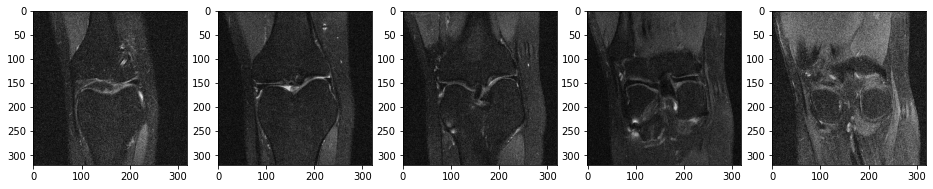

In [11]:
slice_num = [12, 16, 19, 22, 24]
show_slices(img_3d, slice_num, cmap='gray')

2.6556087e-08 0.00019917084


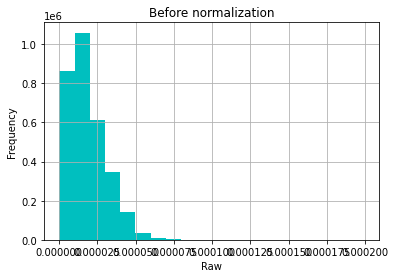

In [12]:
img_flat = img_3d.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [13]:
a = s.normalize(img_3d)
a.shape

(30, 320, 320)

0.0 1.0


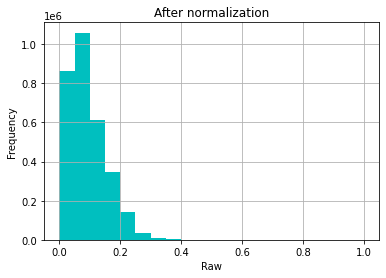

In [14]:
img_flat = a.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("After normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [15]:
# go back to original distribution
c = a * 0.00035430153 + 1.2043776e-08
c.shape

(30, 320, 320)

1.2043776e-08 0.00035431358


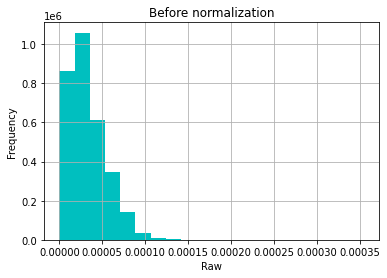

In [16]:
img_flat = c.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [28]:
test_npy_path ="/content/drive/My Drive/CSE499N/Single Coil testNpyFromTrain"

In [30]:
i=0
for file in tqdm(TEST_IMAGES_DIR_PATH[:]):
    i+=1
    
    hf = h5py.File(file)
    
    # transform and save low res image volume
    kspace_tensor = hf['kspace'][()]
    img_3d = sub_sample_kspace(kspace_tensor, _)
    
    # Save 
    np.save("{}/f{}.npy".format(test_npy_path, file[-16:-3]), img_3d) 

    # Show progress
    print(i, file, "raw data - ", kspace_tensor.shape, "--", "input test volume - ", img_3d.shape)


  0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """
  1%|▏         | 1/70 [00:00<00:24,  2.77it/s]

1 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000689.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


  3%|▎         | 2/70 [00:07<02:49,  2.49s/it]

2 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000601.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


  4%|▍         | 3/70 [00:17<05:16,  4.73s/it]

3 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000583.h5 raw data -  (33, 640, 372) -- input test volume -  (33, 320, 320)


  6%|▌         | 4/70 [00:29<07:29,  6.81s/it]

4 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000658.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


  7%|▋         | 5/70 [00:37<07:42,  7.11s/it]

5 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000653.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


  9%|▊         | 6/70 [00:49<09:11,  8.62s/it]

6 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000602.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 10%|█         | 7/70 [01:02<10:29,  9.98s/it]

7 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000663.h5 raw data -  (33, 640, 372) -- input test volume -  (33, 320, 320)


 11%|█▏        | 8/70 [01:22<13:21, 12.93s/it]

8 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000587.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 13%|█▎        | 9/70 [01:25<10:02,  9.87s/it]

9 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000612.h5 raw data -  (45, 640, 372) -- input test volume -  (45, 320, 320)


 14%|█▍        | 10/70 [01:38<10:53, 10.89s/it]

10 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000617.h5 raw data -  (33, 640, 372) -- input test volume -  (33, 320, 320)


 16%|█▌        | 11/70 [02:03<14:54, 15.16s/it]

11 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000610.h5 raw data -  (36, 640, 372) -- input test volume -  (36, 320, 320)


 17%|█▋        | 12/70 [02:15<13:45, 14.24s/it]

12 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000880.h5 raw data -  (36, 640, 372) -- input test volume -  (36, 320, 320)


 19%|█▊        | 13/70 [02:29<13:32, 14.26s/it]

13 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000969.h5 raw data -  (33, 640, 372) -- input test volume -  (33, 320, 320)


 20%|██        | 14/70 [02:33<10:25, 11.16s/it]

14 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000736.h5 raw data -  (41, 640, 372) -- input test volume -  (41, 320, 320)


 21%|██▏       | 15/70 [02:48<11:13, 12.25s/it]

15 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000973.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 23%|██▎       | 16/70 [02:57<10:02, 11.16s/it]

16 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000873.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 24%|██▍       | 17/70 [03:05<09:02, 10.23s/it]

17 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000933.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 26%|██▌       | 18/70 [03:14<08:40, 10.00s/it]

18 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000662.h5 raw data -  (37, 640, 372) -- input test volume -  (37, 320, 320)


 27%|██▋       | 19/70 [03:31<10:08, 11.94s/it]

19 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000874.h5 raw data -  (38, 640, 372) -- input test volume -  (38, 320, 320)


 29%|██▊       | 20/70 [03:39<08:59, 10.80s/it]

20 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000876.h5 raw data -  (33, 640, 372) -- input test volume -  (33, 320, 320)


 30%|███       | 21/70 [03:50<08:59, 11.02s/it]

21 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000638.h5 raw data -  (36, 640, 370) -- input test volume -  (36, 320, 320)


 31%|███▏      | 22/70 [04:00<08:30, 10.64s/it]

22 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000981.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 33%|███▎      | 23/70 [04:06<07:07,  9.09s/it]

23 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000685.h5 raw data -  (29, 640, 372) -- input test volume -  (29, 320, 320)


 34%|███▍      | 24/70 [04:13<06:36,  8.62s/it]

24 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000848.h5 raw data -  (33, 640, 372) -- input test volume -  (33, 320, 320)


 36%|███▌      | 25/70 [04:27<07:33, 10.08s/it]

25 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000833.h5 raw data -  (37, 640, 372) -- input test volume -  (37, 320, 320)


 37%|███▋      | 26/70 [04:35<07:00,  9.55s/it]

26 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000971.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


 39%|███▊      | 27/70 [04:46<07:16, 10.15s/it]

27 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000834.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 40%|████      | 28/70 [04:53<06:25,  9.17s/it]

28 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000865.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 41%|████▏     | 29/70 [05:03<06:27,  9.46s/it]

29 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000970.h5 raw data -  (36, 640, 372) -- input test volume -  (36, 320, 320)


 43%|████▎     | 30/70 [05:15<06:39, 10.00s/it]

30 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000984.h5 raw data -  (33, 640, 372) -- input test volume -  (33, 320, 320)


 44%|████▍     | 31/70 [05:28<07:04, 10.89s/it]

31 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000827.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


 46%|████▌     | 32/70 [05:36<06:19,  9.99s/it]

32 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000954.h5 raw data -  (33, 640, 322) -- input test volume -  (33, 320, 320)


 47%|████▋     | 33/70 [05:57<08:11, 13.27s/it]

33 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000968.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 49%|████▊     | 34/70 [06:05<07:10, 11.95s/it]

34 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000964.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


 50%|█████     | 35/70 [06:14<06:25, 11.03s/it]

35 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000963.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


 51%|█████▏    | 36/70 [06:23<05:53, 10.40s/it]

36 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000661.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 53%|█████▎    | 37/70 [06:38<06:22, 11.58s/it]

37 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000814.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


 54%|█████▍    | 38/70 [06:47<05:48, 10.90s/it]

38 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000994.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 56%|█████▌    | 39/70 [06:55<05:15, 10.17s/it]

39 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000752.h5 raw data -  (33, 640, 322) -- input test volume -  (33, 320, 320)


 57%|█████▋    | 40/70 [07:07<05:14, 10.49s/it]

40 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000863.h5 raw data -  (35, 640, 372) -- input test volume -  (35, 320, 320)


 59%|█████▊    | 41/70 [07:17<05:04, 10.51s/it]

41 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000824.h5 raw data -  (35, 640, 372) -- input test volume -  (35, 320, 320)


 60%|██████    | 42/70 [07:24<04:23,  9.40s/it]

42 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000955.h5 raw data -  (37, 640, 372) -- input test volume -  (37, 320, 320)


 61%|██████▏   | 43/70 [07:35<04:29,  9.99s/it]

43 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000615.h5 raw data -  (37, 640, 372) -- input test volume -  (37, 320, 320)


 63%|██████▎   | 44/70 [07:43<04:00,  9.27s/it]

44 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000988.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 64%|██████▍   | 45/70 [07:53<04:00,  9.61s/it]

45 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000959.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 66%|██████▌   | 46/70 [08:04<03:59,  9.98s/it]

46 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000734.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 67%|██████▋   | 47/70 [08:25<05:04, 13.23s/it]

47 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000808.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 69%|██████▊   | 48/70 [08:34<04:25, 12.08s/it]

48 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000919.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


 70%|███████   | 49/70 [08:44<03:57, 11.30s/it]

49 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000721.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


 71%|███████▏  | 50/70 [08:57<03:54, 11.72s/it]

50 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000639.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 73%|███████▎  | 51/70 [09:09<03:49, 12.06s/it]

51 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000936.h5 raw data -  (36, 640, 372) -- input test volume -  (36, 320, 320)


 74%|███████▍  | 52/70 [09:24<03:50, 12.78s/it]

52 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000995.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


 76%|███████▌  | 53/70 [09:35<03:30, 12.38s/it]

53 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000985.h5 raw data -  (35, 640, 372) -- input test volume -  (35, 320, 320)


 77%|███████▋  | 54/70 [09:49<03:23, 12.71s/it]

54 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000755.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


 79%|███████▊  | 55/70 [10:01<03:07, 12.51s/it]

55 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000723.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


 80%|████████  | 56/70 [10:05<02:18,  9.90s/it]

56 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000784.h5 raw data -  (41, 640, 372) -- input test volume -  (41, 320, 320)


 81%|████████▏ | 57/70 [10:13<02:02,  9.43s/it]

57 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000898.h5 raw data -  (32, 640, 322) -- input test volume -  (32, 320, 320)


 83%|████████▎ | 58/70 [10:22<01:52,  9.38s/it]

58 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000719.h5 raw data -  (33, 640, 372) -- input test volume -  (33, 320, 320)


 84%|████████▍ | 59/70 [10:33<01:48,  9.88s/it]

59 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000821.h5 raw data -  (37, 640, 372) -- input test volume -  (37, 320, 320)


 86%|████████▌ | 60/70 [10:42<01:34,  9.41s/it]

60 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000896.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 87%|████████▋ | 61/70 [10:54<01:32, 10.24s/it]

61 /content/drive/My Drive/CSE499N/Test_fromTrain/file1001001.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 89%|████████▊ | 62/70 [11:09<01:34, 11.86s/it]

62 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000776.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 90%|█████████ | 63/70 [11:16<01:12, 10.33s/it]

63 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000715.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 91%|█████████▏| 64/70 [11:30<01:08, 11.46s/it]

64 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000740.h5 raw data -  (35, 640, 372) -- input test volume -  (35, 320, 320)


 93%|█████████▎| 65/70 [11:40<00:54, 10.89s/it]

65 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000941.h5 raw data -  (32, 640, 388) -- input test volume -  (32, 320, 320)


 94%|█████████▍| 66/70 [11:52<00:44, 11.15s/it]

66 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000904.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 96%|█████████▌| 67/70 [12:09<00:39, 13.04s/it]

67 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000709.h5 raw data -  (35, 640, 372) -- input test volume -  (35, 320, 320)


 97%|█████████▋| 68/70 [12:19<00:24, 12.24s/it]

68 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000768.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 99%|█████████▊| 69/70 [12:30<00:11, 11.83s/it]

69 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000999.h5 raw data -  (38, 640, 368) -- input test volume -  (38, 320, 320)


100%|██████████| 70/70 [12:32<00:00, 10.76s/it]

70 /content/drive/My Drive/CSE499N/Test_fromTrain/file1000682.h5 raw data -  (40, 640, 368) -- input test volume -  (40, 320, 320)


In [31]:
test_path = glob.glob(os.path.join(test_npy_path,"*.npy"))
len(test_path)

70

In [32]:
test_path[:4]

['/content/drive/My Drive/CSE499N/Single Coil testNpyFromTrain/f1.npy',
 '/content/drive/My Drive/CSE499N/Single Coil testNpyFromTrain/f2.npy',
 '/content/drive/My Drive/CSE499N/Single Coil testNpyFromTrain/f3.npy',
 '/content/drive/My Drive/CSE499N/Single Coil testNpyFromTrain/f4.npy']